<div class="alert alert-block alert-warning">
    <b>Warning:</b>
    OpenEye's Hybrid sometimes has difficulties generating the specified number of poses. As `REINVENT` (a major 
    use case) generates a large variety of molecules, we propose that you limit the number of poses to 3. If you 
    still experience "hanging jobs", reduce it to 1.
</div>

<div class="alert alert-block alert-info">
<b>How to run this notebook?</b><br />
<ol>
    <li>Install the DockStream environment: conda env create -f environment.yml in the DockStream directory</li>
    <li>Activate the environment: conda activate DockStreamCommunity</li>
    <li>Execute jupyter: jupyter notebook</li>
    <li> Copy the link to a browser</li>
    <li> Update variables <b>dockstream_path</b> and <b>dockstream_env</b> (the path to the environment DockStream) in the 
        first code block below</li>
    </ol>
</div>


# `OpenEye Hybrid` backend demo
This notebook will demonstrate how to **(a)** set up an `OpenEye Hybrid` backend run with `DockStream`, including the most important settings and **(b)** how to set up a `REINVENT` run with `OpenEye Hybrid` docking enabled as one of the scoring function components.

**Steps:**
* a: Set up `DockStream` run
  1. Prepare the receptor
  2. Prepare the input: SMILES and configuration file (`JSON` format)
  3. Execute the docking and parse the results
* b: Set up `REINVENT` run with a `DockStream` component
  1. Prepare the receptor (see *a.1*)
  2. Prepare the input (see *a.2*)
  3. Prepare the `REINVENT` configuration (`JSON` format)
  4. Execute `REINVENT`

If an `OpenEye` license is available, `DockStream` can make use of its target preparation, ligand embedding and docking capabilities. The license file path should be set as the environment variable _OE_LICENSE_. __Note:__ Make sure, you have activated the `DockStream` environment before launching this notebook. This notebook will deposit all files created into `~/Desktop/Hybrid_demo`.

The following imports / loadings are only necessary when executing this notebook. If you want to use `DockStream` directly from the command-line, it is enough to execute the following with the appropriate configurations:

```
conda activate DockStream
python <path_to_DockStream>/target_preparator.py -conf target_prep.json
python <path_to_DockStream>/docker.py -conf docking.json
```

In [1]:
import os
import json
import tempfile

# update these paths to reflect your system's configuration
dockstream_path = os.path.expanduser("~/Desktop/ProjectData/DockStream")
dockstream_env = os.path.expanduser("~/miniconda3/envs/DockStream")

# no changes are necessary beyond this point
# ---------
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# generate the paths to the entry points
TARGET_PREPARATOR_PATH = os.path.join(dockstream_path, "target_preparator.py")
DOCKER_PATH = os.path.join(dockstream_path, "docker.py")

# generate a folder to store the results
output_dir = os.path.expanduser("~/Desktop/Hybrid_demo")
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

In [2]:
# generate the paths to the files shipped with this implementation
APO_1UYD_PATH = os.path.join(ipynb_path, "../data/1UYD/1UYD_apo.pdb")
REFERENCE_LIGAND_PATH = os.path.join(ipynb_path, "../data/1UYD/PU8.pdb")
SMILES_PATH = os.path.join(ipynb_path, "../data/1UYD/ligands_smiles.txt")

# generate output paths for the configuration file, the "fixed" PDB file and the "Hybrid" receptor
TARGET_PREP_JSON_PATH = os.path.join(output_dir, "Hybrid_target_prep.json")
FIXED_PDB_PATH = os.path.join(output_dir, "Hybrid_fixed_target.pdb")
HYBRID_RECEPTOR_PATH = os.path.join(output_dir, "Hybrid_receptor.oeb")

# generate output paths for the configuration file, embedded ligands, the docked ligands and the scores
DOCKING_CONF_JSON_PATH = os.path.join(output_dir, "Hybrid_docking.json")
LIGANDS_CONFORMERS_PATH = os.path.join(output_dir, "Hybrid_embedded_ligands.sdf")
HYBRID_DOCKED_POSES_PATH = os.path.join(output_dir, "Hybrid_docked_poses.sdf")
HYBRID_DOCKED_SCORES_PATH = os.path.join(output_dir, "Hybrid_docked_scores.csv")

## Target Preparation
`OpenEye` has its own binary receptor format (with `.oeb` or `.oeb.gz` as mandatory endings) and we will need to provide one of these files for the docking process later. This is a semi-automated process and while `DockStream` has an entry point to help you setting this up, it might be wise to think about the details of this process beforehand, including:
* Is my target structure complete (e.g. has it missing loops in the area of interest)?
* Do I have a reference ligand in a complex (holo) structure or do I need to define the binding cleft (cavity) in a different manner?
* Do I want to keep the crystal water molecules, potential co-factors and such or not?

This step has to be done once per project and target. Typically, we start from a PDB file with a holo-structure, that is, a protein with its ligand. Using a holo-structure as input is convenient for two reasons:
1. The cavity can be specified as being a certain area around the ligand in the protein (assuming the binding mode does not change too much).
2. One can align other ligands (often a series with considerable similarity is used in docking studies) to the "reference ligand", potentially improving the performance.

`OpenEye` offers two other ways to define the cavity (both supported by `DockStream`) but they are beyond the scope of this notebook. Our testcase here will use a public dataset of [1UYD](https://www.rcsb.org/structure/1UYD), a crystal structure of human HSP90-alpha in complex with a ligand. The 15 ligands have been taken from a [blog post](https://www.discngine.com/blog/2019/6/6/tethered-minimization-of-small-molecules-with-rdkit-towards-tethered-docking-on-proteins-with-rdock) from Peter Schmidtke.

![](img/target_preparation_template_method.png)

For this notebook, it is assumed that you are able to

1. download `1UYD` and
2. split it into `1UYD_apo.pdb` and `reference_ligand.pdb` (name is `PU8` in the file), respectively.

We will now set up the `JSON` instruction file for the target preparator that will help us build a receptor suitable for `OpenEye` docking later. We will also include a small section (internally using [PDBFixer](https://github.com/openmm/pdbfixer)) that will take care of minor problems of the input structure, such as missing hetero atoms - but of course you can address these things with a program of your choice as well. We will write the `JSON` to the output folder in order to load it with the `target_preparator.py` entry point of `DockStream`.

In [3]:
# specify the target preparation JSON file as a dictionary and write it out
hybrid_tp_dict = {
  "target_preparation":
  {
    "header": {                                   # general settings
      "environment": {
        "export": [{                              # while you may also load the "OpenEye" license file variable in the
                                                  # console, this block allows to export environment variables for each run
            "key": "OE_LICENSE",
            "value": "/opt/scp/software/oelicense/1.0/oe_license.seq1"
          }]
      }
    },
    "input_path": APO_1UYD_PATH,                  # this should be an absolute path
    "fixer": {                                    # based on "PDBFixer"; tries to fix common problems with PDB files
      "enabled": True,
      "standardize": True,                        # enables standardization of residues
      "remove_heterogens": True,                  # remove hetero-entries
      "fix_missing_heavy_atoms": True,            # if possible, fix missing heavy atoms
      "fix_missing_hydrogens": True,              # add hydrogens, which are usually not present in PDB files
      "fix_missing_loops": False,                 # add missing loops; CAUTION: the result is usually not sufficient
      "add_water_box": False,                     # if you want to put the receptor into a box of water molecules
      "fixed_pdb_path": FIXED_PDB_PATH            # if specified and not "None", the fixed PDB file will be stored here
    },
    "runs": [                                     # "runs" holds a list of backend runs; at least one is required
      {
        "backend": "OpenEye",                     # one of the backends supported ("OpenEye", "rDock", ...)
        "output": {
          "receptor_path": HYBRID_RECEPTOR_PATH   # the generated receptor file will be saved to this location
        },
        "parameters": {},
        "cavity": {                               # there are different ways to specify the cavity; here, a reference
                                                  # ligand is used
          "method": "reference_ligand",
          "reference_ligand_path": REFERENCE_LIGAND_PATH,
          "reference_ligand_format": "pdb"
}}]}}

with open(TARGET_PREP_JSON_PATH, "w+") as f:
    json.dump(hybrid_tp_dict, f, indent=2)

In [4]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {TARGET_PREPARATOR_PATH} -conf {TARGET_PREP_JSON_PATH}

This is it, now we have **(a)** fixed some minor issues with the input structure and **(b)** generated a reference ligand-based receptor and stored it in a binary file. For inspection later, we will write out the "fixed" PDB structure (parameter `fixed_pdb_path` in the `fixer` block above).

## Docking
In this section we consider a case, where we have just prepared the receptor and want to dock a bunch of ligands (molecules, compounds) into the binding cleft. Often, we only have the structure of the molecules in the form of `SMILES`, rather than a 3D structure so the first step will be to generate these conformers before proceeding. In `DockStream` you can embed your ligands with a variety of programs including `Corina`, `RDKit`, `OMEGA` and `LigPrep` and use them freely with any backend. However, here we will use `Corina` for the conformer embedding.

But first, we will have a look at the ligands:

In [5]:
# load the smiles (just for illustrative purposes)
# here, 15 moleucles will be used
with open(SMILES_PATH, 'r') as f:
    smiles = [smile.strip() for smile in f.readlines()]
print(smiles)

['C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)ncnc21', 'CCCCn1c(Cc2cccc(OC)c2)nc2c(N)ncnc21', 'C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc(OC)cc2)nc2c(N)ncnc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21', 'C#CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Cc2cc3c(cc2I)OCO3)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2Br)OCO3)nc2c(N)ncnc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21', 'COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1', 'Nc1nccn2c(NCc3ccccc3)c(Cc3cc4c(cc3Br)OCO4)nc12']


While the embedding and docking tasks in `DockStream` are both specified in the same configuration file, they are handled independently. This means it is perfectly fine to either load conformers (from an `SDF` file) directly or to use a call of `docker.py` merely to generate conformers without doing the docking afterwards.

`DockStream` uses the notion of (embedding) "pool"s, of which multiple can be specified and accessed via identifiers. Note, that while the way conformers are generated is highly backend specific, `DockStream` allows you to use the results interchangably. This allows to (a) re-use embedded molecules for multiple docking runs (e.g. different scoring functions), without the necessity to embed them more than once and (b) to combine embeddings and docking backends freely.

In [6]:
# specify the embedding and docking JSON file as a dictionary and write it out
hybrid_corina_conf_json = {
  "docking": {
    "header": {                                   # general settings
      "environment": {
        "export": [{
            "key": "OE_LICENSE",
            "value": "/opt/scp/software/oelicense/1.0/oe_license.seq1"
          }]
      }
    },
    "ligand_preparation": {                     # the ligand preparation part, defines how to build the pool
      "embedding_pools": [
        {
          "pool_id": "Corina",                  # here, we only have one pool, but we could also use RDkit and/or LigPrep
          "type": "Corina",
          "parameters": {
            "prefix_execution": "module load corina"                    
          },
          "input": {
            "standardize_smiles": False,         # usually, this does not have any effect
            "type": "smi",
            "input_path": SMILES_PATH
          },
          "output": {                                       # the conformers can be written to a file, but "output" is
                                                            # not required as the ligands are forwarded internally
            "conformer_path": LIGANDS_CONFORMERS_PATH, 
            "format": "sdf"
          }
        }
      ]
    },
    "docking_runs": [
      {
        "backend": "Hybrid",                                # specify the backend
        "run_id": "Hybrid_Corina",                          # give any (unique) run ID
        "input_pools": ["Corina"],                          # select, which pool should be used as input
        "parameters": {                                     # these are backend-specific parameters
          "prefix_execution": "module load oedocking",
          "parallelization": {
            "number_cores": 2,
            "max_compounds_per_subjob": 1
          },
            "receptor_paths": [HYBRID_RECEPTOR_PATH],
            "resolution": "High",                            # exhaustive search resolution ("Low, Standard, or High")
            "num_poses": 3                                  # number of docked poses to output for each ligands
        },
        "output": {
          "poses": { "poses_path": HYBRID_DOCKED_POSES_PATH },
          "scores": { "scores_path": HYBRID_DOCKED_SCORES_PATH }
}}]}}

with open(DOCKING_CONF_JSON_PATH, "w+") as f:
    json.dump(hybrid_corina_conf_json, f, indent=2)

In [7]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {DOCKER_PATH} -conf {DOCKING_CONF_JSON_PATH} -print_scores

-8.676099
-10.177081
-9.480708
-10.517886
-9.436307
-10.666023
-10.770368
-9.949238
-10.126225
-10.239015
-8.864778
-7.844204
-8.00174
-10.222501
-13.016709


Note, that the scores are usually outputted to a `CSV` file specified by the `scores` block, but that since we have used parameter `-print_scores` they will also be printed to `stdout` (line-by-line).

These scores are associated with docking poses (see picture below for a couple of ligands overlaid in the binding pocket).

![](img/docked_ligands_overlay_holo.png)

## Using `DockStream` as a scoring component in `REINVENT`

<div class="alert alert-block alert-warning">
    <b>Warning:</b>
    OpenEye's Hybrid sometimes has difficulties generating the specified number of poses, in which case the job 
    "hangs" and does not complete. As REINVENT generates a large variety of molecules, we propose that you limit 
    the number of poses to 3. If you still experience "hanging jobs", reduce it to 1.
</div>

The *de novo* design platform `REINVENT` holds a recently added `DockStream` scoring function component (also check out our collection of notebooks in the [ReinventCommunity](https://github.com/MolecularAI/ReinventCommunity) repository). This means, provided that all necessary input files and configurations are available, you may run `REINVENT` and incorporate docking scores into the score of the compounds generated. Together with `FastROCS`, this represents the first step to integrate physico-chemical 3D information.

While the docking scores are a very crude proxy for the actual binding affinity (at best), it does prove useful as a *geometric filter* (removing ligands that obviously do not fit the binding cavity). Furthermore, a severe limitation of knowledge-based predictions e.g. in activity models is the domain applicability. Docking, as a chemical space agnostic component, can enhance the ability of the agent for scaffold-hopping, i.e. to explore novel sub-areas in the chemical space.

### The `REINVENT` configuration JSON

While every docking backend has its own configuration (see section above), calling `DockStream`'s `docker.py` entry point ensures, that they all follow the same external API. Thus the component that needs to be added to `REINVENT`'s JSON configuration (to the `scoring_function`->`parameters` list) looks as follows (irrespective of the backend):

```
{
    "component_type": "dockstream",
    "name": "dockstream",
    "weight": 1,
    "specific_parameters": {
        "transformation": {
            "transformation_type": "reverse_sigmoid",
            "low": -16,
            "high": -8,
            "k": 0.25
         },
        "configuration_path": "<absolute_path_to_DockStream_configuration>/docking.json",
        "docker_script_path": "<absolute_path_to_DockStream_source>/docker.py",
        "environment_path": "<absolute_path_to_miniconda_installation>/envs/DockStream/bin/python"
    }
}
```

You will need to update `configuration_path`, `docker_script_path` and the link to the environment, `environment_path` to match your system's configuration. It might be, that the latter two are already set to meaningful defaults, but your `DockStream` configuration JSON file will be specific for each run. 

#### How to find an appropriate transformation?
We use a *reverse sigmoid* score transformation to bring the numeric, continuous value that was outputted by `DockStream` and fed back to `REINVENT` into a 0 to 1 regime. The parameters `low`, `high` and `k` are critical: their exact value naturally depends on the backend used, but also on the scoring function (make sure, "more negative is better" - otherwise you are looking for a *sigmoid* transformation) and potentially also the project used. The values reported here can be used as rule-of-thumb for a `Hybrid` run with `Chemgauss4` docking score.

To fine-tune your parameters, it might be a good idea to run a couple of molecules using your docking protocol and subsequently decide how the transformation should be adjusted. For example, if your test run yields, say, -11.9, -12.9 and -9.8 for *good* ligands and -5.8, -7.1 and -6.5 for *decoys*, you could adjust `k`, `low`and `high` such, that it assignes a score close to `1` for everything below -10 and a score close to `0` for everything above -6, with a somewhat "smooth" interpolation which is set by parameter `k` (so that the agent "can-pick-up-the-trail"). Of course, you do not necessarily need decoys as long as you know in which docking score range you would like to stay. We strongly recommend to use the `REINVENT` score transformation `jupyter` notebook for this purpose.


In [8]:
# load the dependencies and classes used
%run code/score_transformation.py

# set plotting parameters
small = 12
med = 16
large = 22
params = {"axes.titlesize": large,
          "legend.fontsize": med,
          "figure.figsize": (16, 10),
          "axes.labelsize": med,
          "axes.titlesize": med,
          "xtick.labelsize": med,
          "ytick.labelsize": med,
          "figure.titlesize": large}
plt.rcParams.update(params)
plt.style.use("seaborn-whitegrid")
sns.set_style("white")
%matplotlib inline

# set up Enums and factory
tt_enum = TransformationTypeEnum()
csp_enum = ComponentSpecificParametersEnum()
factory = TransformationFactory()

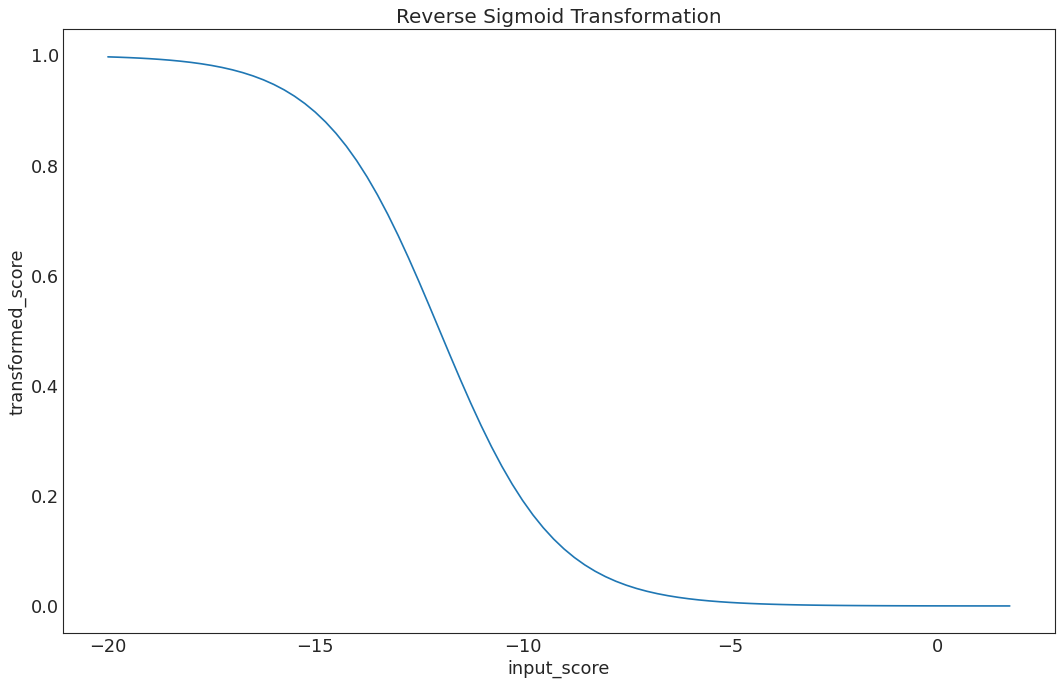

In [9]:
# reverse sigmoid transformation
# ---------
values_list = np.arange(-20, 2, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -16,
                       csp_enum.HIGH: -8,
                       csp_enum.K: 0.25,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.REVERSE_SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Reverse Sigmoid Transformation", x=values_list, y=transformed_scores)

### How to specify the `DockStream` configuration file?
In principle, all options that are supported in a "normal" `DockStream` run (see above) are supported for usage with `REINVENT` as well, with a few notable exceptions. First, as we report only one value per ligand (and a "consensus score" is not yet supported), you should only use **one** embedding / pool and **one** backend (as in the example above). Second, the prospective ligands are not supplied via a file but from `stdin`, thus we will need to change the `input` part of the pool definition. Also, we might not want to write-out all conformers, so we will remove the `output` block entirely. The updated section then looks as follows:

```
{
    "pool_id": "Corina_pool",
    "type": "Corina",
    "parameters": {
        "removeHs": False
     },
     "input": {
         "standardize_smiles": False
     }
}
```

Finally, we will update the docking run as well. Typically, we want to see the docked poses per epoch and maybe also the scores and the SMILES in a well-tabulated format. Thus, we might retain the `output` block here, but as every epoch generates each of the files, it would overwrite it by default. If parameter `overwrite` is set to `False`, each consecutive write-out will be appended by a number, e.g. first epoch *poses.sdf* and *scores.csv*, second epoch *0001_poses.sdf* and *0001_scores.csv*, third epoch *0002_poses.sdf* and *0002_scores.csv* and so on.

```
{
    "backend": "Hybrid",
    "run_id": "Hybrid_run",
    "input_pools": ["Corina_pool"],
    "parameters": {
        "receptor_paths": ["<absolute_path_to_receptor_file>/receptor.oeb"],
        "resolution": "High",
        "number_poses": 1
    },
    "output": {
        "poses": { "poses_path": "<absolute_path_to_poses_stem_file>/poses.sdf", "overwrite": False },
        "scores": { "scores_path": "<absolute_path_to_scores_stem_file>/scores.csv", "overwrite": False }
    }
}
```